In [1]:
using Test
using StatsBase
using Distributions
using Plots
using FFTW


(process:10708): GLib-GIO-WARNING **: 09:27:36.877: Unexpectedly, UWP app `D5BE6627.UltraZipOpener_2.0.6.0_neutral__9pm2v9747qaaa' (AUMId `D5BE6627.UltraZipOpener_9pm2v9747qaaa!App') supports 127 extensions but has no verbs

(process:10708): GLib-GIO-WARNING **: 09:27:36.986: Unexpectedly, UWP app `KDEe.V.Okular_22.801.1132.0_x64__7vt06qxq7ptv8' (AUMId `KDEe.V.Okular_7vt06qxq7ptv8!KDEe.V.Okular') supports 5 extensions but has no verbs

(process:10708): GLib-GIO-WARNING **: 09:27:37.173: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.0.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


# Empirical distribution

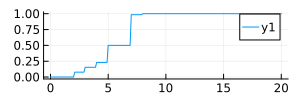

In [2]:
observations = [2.1, 3, 4, 5, 7, 8]
weights = Weights([1, 1, 1, 3.5, 6.3, 0.2])
empirical_distribution = ecdf(observations; weights)
xs = [i for i in 0:0.1:20]
ys = [empirical_distribution(x) for x in xs]
plot(xs,ys, size = (300, 100))

# Convolution of two distributions, FFT

In [3]:
function slow_convolution(v_1, v_2)
    for x in base_points_1
        l = div(x, step)
        tot = 0
        for i in 0:(l-1)
            tot += v_1[i + 1] * v_2[l-i]
        end
        push!(convolution, tot)
    end
    return convolution
end

slow_convolution (generic function with 1 method)

In [4]:
function fft_conv(d_1, d_2, limit)
    q = max(quantile(d_1, 1-limit), quantile(d_2, 1-limit))
    print(q)
    grid = 0:1:round(q)
    vector_values_1 = [pdf(d_1, x) for x in grid]
    vector_values_2 = [pdf(d_2, x) for x in grid]
    vector_conv = real(ifft(fft(vector_values_1).*fft(vector_values_2)))
    weights = Weights(vector_conv)
    return ecdf(grid; weights)
end

fft_conv (generic function with 1 method)

In [19]:
# standard convolution
b_1, b_2 = Binomial(1000, 0.2), Binomial(2000, 0.2)
cv_analytic = convolve(b_1, b_2)
cv_fft = fft_conv(b_1, b_2, 1e-30)
xs_test = 300:1200
p_analytic = plot(xs_test, [cdf(cv_analytic, x) for x in xs_test])
p_fft = plot(xs_test, [cv_fft(x) for x in xs_test])
p_tot = plot(xs_test, [cdf(Binomial(3000, 0.2), x) for x in xs_test])
plot(p_analytic, p_fft, p_tot, layout = (1, 3), size = (600, 100), label=["analytic" "fft" "tot"])

2000

## Plot histogram and function on the same graph

2000

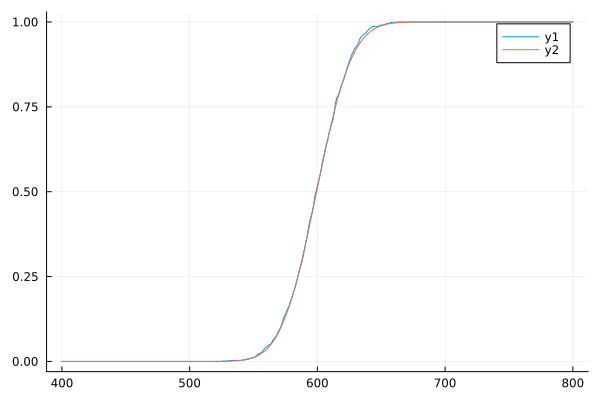

In [27]:
bin_1, bin_2 = Binomial(1000, 0.2), Binomial(2000, 0.2)
draws = [rand(bin_1) + rand(bin_2) for x in 1:1000]
rangg = 400:800
histo_cdf = [count(draws .< x) for x in rangg] ./ 1000

binomial_fft = fft_conv(bin_1, bin_2, 1e-30)
plot(rangg, histo_cdf)
plot!(rangg, [binomial_fft(x) for x in rangg])

# Frequency-severity model

In [7]:
struct FrequencySeverity{F <: DiscreteUnivariateDistribution, S <: ContinuousUnivariateDistribution} 
    frequency::F
    severity::S
end

In [8]:
function StatsBase.rand(fs::FrequencySeverity)::Real
    tot = 0
    f = rand(fs.frequency)
    if f == 0 return 0 end
    for i in 1:f
        tot += rand(fs.severity)
    end
    return tot
end

function StatsBase.rand(fs::FrequencySeverity, n::Int)
    return [StatsBase.rand(fs) for x in 1:n]
end

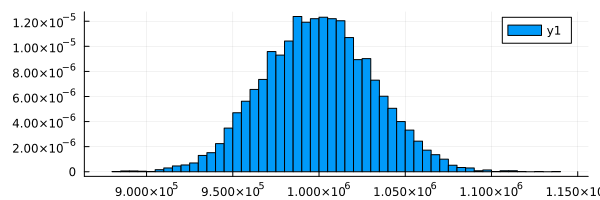

In [9]:
example_frequency = Poisson(1000)
example_severity = Gamma(100, 10)
ex_d = FrequencySeverity(example_frequency, example_severity)
draws = rand(ex_d, 10_000)
histogram(draws, norm = true, size = (600, 200))

### The quantile of a frequency-severity model

In [10]:
fs_pareto = Pareto(5, 1000)
fs_poisson = Poisson(40)
ex_fs = FrequencySeverity(fs_poisson, fs_pareto)
fs_draws = rand(ex_fs, 200_000)
ccdf = ecdf(fs_draws)

ECDF{Vector{Float64}, Weights{Float64, Float64, Vector{Float64}}}([16241.247454646767, 19145.529057105356, 19357.317908481902, 19568.451241712828, 19712.281664733164, 19929.571177886068, 20218.534299898944, 20823.53680357651, 21287.9817347712, 21366.724833576543  …  85624.89276530888, 85628.64947140533, 86678.11301116583, 86863.03598564726, 87336.82939721779, 87346.21897762745, 87387.05278180588, 87516.89765580234, 88687.24886670682, 90338.724076486], Float64[])

In [11]:
quantile_fs_draws = findfirst(x -> x >= 0.999, [ccdf(x) for x in 1:200_000])

77083

In [12]:
quantile_approx = quantile(ex_fs.severity, 1 - (1 - 0.9999)/mean(ex_fs.frequency)) + (mean(ex_fs.frequency) - 1)*mean(ex_fs.severity)

61945.07910771165

### Define moment-generating function for complex values

In [13]:
function Distributions.mgf(d::Poisson, t::Complex)
    λ = rate(d)
    return exp(λ * (exp(t) - 1))
end

### Apply FFT

In [14]:
fs = FrequencySeverity(Poisson(1000), Gamma(100, 10))

function empirical_max_value(freq_sev::FrequencySeverity)::Int
    n_trials = 100000
    draws = rand(freq_sev, n_trials)
    ccdf = ecdf(fs_draws)
    return Int(ceil(max(draws...))) * 2
end

function empirical_max_value(freq_sev::FrequencySeverity{F, S}, q::Real) where {F<:Poisson, S<:Gamma}
    a = Int(ceil(quantile(freq_sev.frequency, 0.999) * quantile(freq_sev.severity, 0.999)))
    return div(a*5, 4)
end

function empirical_max_value(freq_sev::FrequencySeverity{F, S}, q::Real) where {F<:Poisson, S<:Pareto}
    a = quantile(freq_sev.severity, 1 - (1 - 0.9999)/mean(freq_sev.frequency)) + (mean(freq_sev.frequency) - 1)*mean(freq_sev.severity)
    return div(a*3, 2)
end

function FFTW.fft(freq_sev::FrequencySeverity)
    e_end = empirical_max_value(freq_sev)
    stp = 1000
    rng = 0:stp:(e_end-1)
    stps = length(rng)
    println(e_end)
    step_pdf = cdf.(freq_sev.severity, rng[2:end]) .- cdf.(freq_sev.severity, rng[1:(end - 1)])
    severity_ft = fft(step_pdf)
    total_claim_amount_ft = mgf.(fs.frequency, log.(severity_ft))
    return ecdf(rng[2:end]; weights = real(ifft(total_claim_amount_ft)))
end

function fft_bot(freq_sev::FrequencySeverity)
    e_end = empirical_max_value(freq_sev)
    stp = 1000
    rng = 0:stp:(e_end-1)
    stps = length(rng)
    step_pdf = cdf.(freq_sev.severity, rng[2:end]) .- cdf.(freq_sev.severity, rng[1:(end - 1)])
    severity_ft = fft(step_pdf)
    total_claim_amount_ft = mgf.(fs.frequency, log.(severity_ft))
    return ecdf(rng[1:(end - 1)]; weights = real(ifft(total_claim_amount_ft)))
end

function fft_top(freq_sev::FrequencySeverity)
    e_end = empirical_max_value(freq_sev)
    stp = 1000
    rng = 0:stp:(e_end-1)
    stps = length(rng)
    step_pdf = cdf.(freq_sev.severity, rng[2:end]) .- cdf.(freq_sev.severity, rng[1:(end - 1)])
    severity_ft = fft(step_pdf)
    total_claim_amount_ft = mgf.(fs.frequency, log.(severity_ft))
    return ecdf(rng[2:end]; weights = real(ifft(total_claim_amount_ft)))
end


convolution_fs_bot = fft_bot(fs)
convolution_fs_top = fft_top(fs)

ECDF{StepRange{Int64, Int64}, Weights{Float64, Float64, Vector{Float64}}}(1000:1000:2362000, [-3.7226783890902794e-17, -5.881771562254411e-17, -8.237340437438308e-17, -1.0200000036506988e-16, -1.1952635778908149e-16, -1.388934330296301e-16, -1.542455995624113e-16, -1.6991400630419043e-16, -1.8307323957485327e-16, -1.9563694589578823e-16  …  2.23993786660912e-16, 1.9630342277762133e-16, 1.6931624560822183e-16, 1.4030147160453848e-16, 1.1554838284194295e-16, 8.673580072408597e-17, 6.084779827989804e-17, 3.614938884126552e-17, 1.054964012063638e-17, -1.4001648885470807e-17])

396900
585225


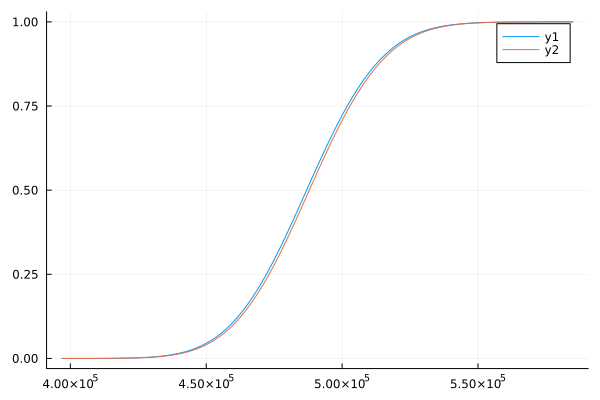

In [15]:
observation_plot = plot()

bot = first(Iterators.filter(x -> convolution_fs_bot(x) > 0.00001, [t^2 for t in 0:100000]))

top = first(Iterators.filter(x -> convolution_fs_bot(x) > 0.99999, [t^2 for t in 0:100000]))
println(bot)
println(top)

plot!(bot:1000:top, [convolution_fs_bot(x) for x in bot:1000:top])
plot!(bot:1000:top, [convolution_fs_top(x) for x in bot:1000:top])

display(observation_plot)

In [16]:
diff = 111200
convolution_fs_top(1000000) - convolution_fs_bot(1000000 - diff)

-3.879119248040297e-13

In [17]:
fs_2 = FrequencySeverity(Poisson(10), Pareto(1.2, 1e5))

conv_fs = fft(fs_2)

[conv_fs(x) for x in 1e5:1e4:5e5]

10100638372


41-element Vector{Float64}:
 1.3263051617010926e-8
 1.4589340007947732e-8
 1.5915625349695433e-8
 1.7241907642265902e-8
 1.856818688566567e-8
 1.9894463079907875e-8
 2.122073622500109e-8
 2.254700632095658e-8
 2.387327336778461e-8
 2.5199537365494547e-8
 2.65257983140953e-8
 2.7852056213600604e-8
 2.917831106401763e-8
 ⋮
 5.172417702064347e-8
 5.305037698923402e-8
 5.437657390893073e-8
 5.570276777974337e-8
 5.702895860168325e-8
 5.8355146374760915e-8
 5.968133109898526e-8
 6.100751277436696e-8
 6.233369140091636e-8
 6.365986697864275e-8
 6.498603950755675e-8
 6.631220898767036e-8

In [18]:
obs_plot = plot()

bot = first(Iterators.filter(x -> conv_fs(x) > 0.00001, [t^2 for t in 0:100000]))


top = first(Iterators.filter(x -> conv_fs(x) > 0.99999, [t^2 for t in 1:100000]))

plot!(bot:div(top - bot, 1000):top, [convolution_fs(x) for x in bot:div(top - bot, 1000):top])
display(obs_plot)

LoadError: ArgumentError: collection must be non-empty

## How to determine the domain of plot?

### Panjer Algorithm